In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

from PIL import Image

In [3]:
PATH = './Dataset/'

In [4]:
def return_data_label(fileName):
    df = pd.read_csv(filepath_or_buffer=PATH+fileName)
    if(fileName != 'test.csv'):
        label = np.array(df['label'])
        data = np.array(df[df.columns[1:]],dtype=np.float)
        new_data = np.reshape(a=data,newshape=(data.shape[0],28,28))
        return new_data, label
    else:
        data = np.array(df,dtype=np.float)
        new_data = np.reshape(a=data,newshape=(data.shape[0],28,28))
        return new_data
        

In [5]:
trainData, trainLabel = return_data_label('train.csv')
testData = return_data_label('test.csv')

In [6]:
#preprocessing the dataset
trainData = trainData / 255
trainData = (trainData - 0.5)/0.5

testData = testData / 255
testData = (testData - 0.5)/0.5

trainData = torch.from_numpy(trainData)
testData = torch.from_numpy(testData)
trainData, testData = trainData.type(torch.FloatTensor), testData.type(torch.FloatTensor)

In [7]:
trainData = trainData.unsqueeze_(dim=1)
testData = testData.unsqueeze_(dim=1)

In [8]:

trainDataset = torch.utils.data.TensorDataset(trainData,torch.tensor(trainLabel))
trainDataLoader = torch.utils.data.DataLoader(trainDataset,batch_size=100,shuffle=False, num_workers=4)

# testDataset = torch.utils.data.TensorDataset(testData)
testDataLoader = torch.utils.data.DataLoader(testData,batch_size=100,shuffle=False, num_workers = 4)

In [10]:
print("Training batches == \n",len(trainData))
print("Testing batches == \n",len(testData))

Training batches == 
 42000
Testing batches == 
 28000


In [61]:
#visualizing no. of examples of each type
def total_count(loader):
    totalClassCount = [0,0,0,0,0,0,0,0,0,0]

    for batch_id,(images,labels) in enumerate(loader):
        for label in labels:
            totalClassCount[label.item()] += 1
    return totalClassCount

Digit class =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Text(0.5,1,'Train Set')

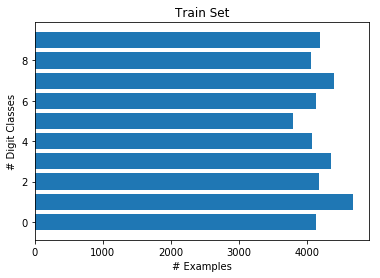

In [66]:
classes = [0,1,2,3,4,5,6,7,8,9]
print("Digit class = ",classes)
totalCount = total_count(trainDataLoader)

fig0, ax0 = plt.subplots()
ax0.barh(y=classes,width=totalCount)
ax0.set_xlabel('# Examples')
ax0.set_ylabel('# Digit Classes')
ax0.set_title('Train Set')


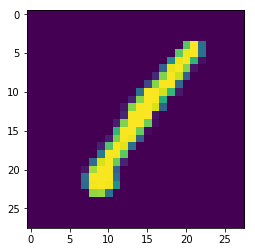

In [73]:
#Visualizing single digit:
temp = trainDataLoader.dataset[0][0].numpy()
temp = np.reshape(a=temp,newshape=(temp.shape[1],temp.shape[2]))
plt.imshow(temp)

That's 1

In [12]:
#Creating LeNet5 nn class module
# conv2d => relu => maxpooling => conv2d => relu => maxpooling => fully connected layer(fc)1 
#=> fc2 => softmax output

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        
        self.fc1 = nn.Linear(1024,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        self.fc1Size = 0
        self.toKnowMaxPoolSize= False
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)),1)
        
        if(self.toKnowMaxPoolSize == True):
            self.fc1Size = x.size()
            print(x.size())
            return
        #now lets reshape the matrix i.e. unrolling the matrix
        x = x.view(x.size()[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
device = torch.device("cuda" if(torch.cuda.is_available()) else "cpu")
n1 = Net()
n1 = n1.to(device)

In [14]:
print(n1)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [15]:
#Creating function for training our NNs
def train_model(model,mode,decay,criterion,dataloader,optimizer,dictionary,num_epochs=30):
    #mode = True means model.train() and False is model.eval()
    #decay = True means decrease LR with no. of epochs 
    
    totalLoss = []
    totalLRs = []
    correct = 0
    total = 0
    LR = 0
    
    for epoch in range(num_epochs):
        if(decay == True):
            for param in optimizer.param_groups:
                LR = param['lr'] * (0.1**(epoch//7))
                param['lr'] = LR
            totalLRs.append(LR)
            
        print("Epoch = {}/{} ".format(epoch,num_epochs),end=" ")
        for batch_id,(image, label) in enumerate(dataloader):
            
            if(mode == True):
                optimizer.zero_grad()
                image = image.to(device)
                label = label.to(device)
            else:
                image = image.to(device)

            output = model.forward(image)
            
            if(mode == True):
                loss = criterion(output,label)

            _, predictated = torch.max(output.data,1)
            
            if(mode == True):
                correct += (predictated == label).sum().item()
                total += label.size(0)

                loss.backward()
                optimizer.step()

            del image,label
            
        torch.cuda.empty_cache()
        print("Loss = {:.5f}".format(loss.item()))
        totalLoss.append(loss)
        
    dictionary['totalLoss'] = totalLoss
    dictionary['correct'] = correct
    dictionary['totalSize'] = total
    dictionary['totalLRs'] = totalLRs
    
    return model,dictionary

In [16]:
# forward => loss => backward => upadte weights
n1.toKnowMaxPoolSize = False   # To print the size of the last maxpool layer.
optimizer = torch.optim.SGD(n1.parameters(),lr=0.1)
criterion = nn.CrossEntropyLoss().cuda()

In [17]:
#Let's first find correct Learning Rate using Learning decay.

dictModel = {}
n1, dictModel = train_model(model=n1,mode=True,decay=True,criterion=criterion,dataloader=trainDataLoader,optimizer=optimizer,dictionary=dictModel,num_epochs=50)

Epoch = 0/50  Loss = 0.13387
Epoch = 1/50  Loss = 0.06255
Epoch = 2/50  Loss = 0.02160
Epoch = 3/50  Loss = 0.01414
Epoch = 4/50  Loss = 0.00917
Epoch = 5/50  Loss = 0.00965
Epoch = 6/50  Loss = 0.00627
Epoch = 7/50  Loss = 0.00191
Epoch = 8/50  Loss = 0.00195
Epoch = 9/50  Loss = 0.00195
Epoch = 10/50  Loss = 0.00195
Epoch = 11/50  Loss = 0.00195
Epoch = 12/50  Loss = 0.00195
Epoch = 13/50  Loss = 0.00195
Epoch = 14/50  Loss = 0.00195
Epoch = 15/50  Loss = 0.00195
Epoch = 16/50  Loss = 0.00195
Epoch = 17/50  Loss = 0.00195
Epoch = 18/50  Loss = 0.00195
Epoch = 19/50  Loss = 0.00195
Epoch = 20/50  Loss = 0.00195
Epoch = 21/50  Loss = 0.00195
Epoch = 22/50  Loss = 0.00195
Epoch = 23/50  Loss = 0.00195
Epoch = 24/50  Loss = 0.00195
Epoch = 25/50  Loss = 0.00195
Epoch = 26/50  Loss = 0.00195
Epoch = 27/50  Loss = 0.00195
Epoch = 28/50  Loss = 0.00195
Epoch = 29/50  Loss = 0.00195
Epoch = 30/50  Loss = 0.00195
Epoch = 31/50  Loss = 0.00195
Epoch = 32/50  Loss = 0.00195
Epoch = 33/50  Loss 

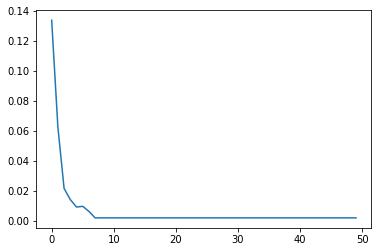

In [18]:
# LOSS vs EPOCHS
plt.plot(dictModel['totalLoss'])

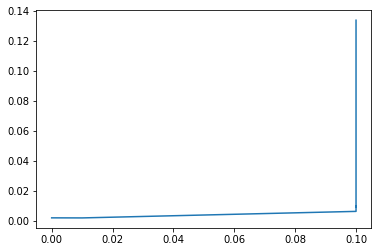

In [19]:
# Loss vs LR 
plt.plot(dictModel['totalLRs'],dictModel['totalLoss'])

In [20]:
print("Accuracy == ",100*(dictModel['correct']/dictModel['totalSize']))

Accuracy ==  99.21161904761905


It can be seen from the above graph of Loss vs Learning Rate, Loss remains low for the LRs = 0.001,0.002,..0.008 till 0.01. So Keeping LR = 0.005 will still yeild us good results and would help us to converge fast. This method helps us to find Better Learning rate by decreasing LR every epoch. Plotting this graph gives us insights about when the loss is least at which LR.

In [46]:
# forward => loss => backward => upadte weights
n1.toKnowMaxPoolSize = False     # To print the size of the last maxpool layer.
optimizer = torch.optim.SGD(n1.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss().cuda()

dictModel = {}
n1, dictModel = train_model(model=n1,mode=True,decay=False,criterion=criterion,dataloader=trainDataLoader,optimizer=optimizer,dictionary=dictModel,num_epochs=20)

Epoch = 0/20  Loss = 0.00019
Epoch = 1/20  Loss = 0.00019
Epoch = 2/20  Loss = 0.00018
Epoch = 3/20  Loss = 0.00018
Epoch = 4/20  Loss = 0.00018
Epoch = 5/20  Loss = 0.00018
Epoch = 6/20  Loss = 0.00017
Epoch = 7/20  Loss = 0.00017
Epoch = 8/20  Loss = 0.00017
Epoch = 9/20  Loss = 0.00017
Epoch = 10/20  Loss = 0.00016
Epoch = 11/20  Loss = 0.00016
Epoch = 12/20  Loss = 0.00016
Epoch = 13/20  Loss = 0.00015
Epoch = 14/20  Loss = 0.00015
Epoch = 15/20  Loss = 0.00015
Epoch = 16/20  Loss = 0.00015
Epoch = 17/20  Loss = 0.00014
Epoch = 18/20  Loss = 0.00014
Epoch = 19/20  Loss = 0.00014


Text(0.5,1,'Train Dataset')

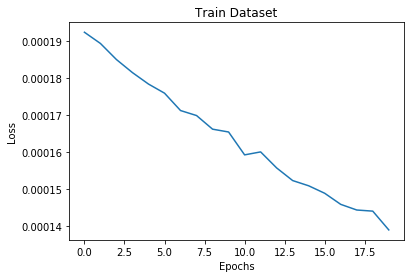

In [47]:
plt.plot(dictModel['totalLoss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Dataset')

In [48]:
#Accuracy
print("Accuracy == ",100*(dictModel['correct']/dictModel['totalSize']))

Accuracy ==  100.0


In [49]:
#evaluating test set
# forward => loss => backward => upadte weights
n1.toKnowMaxPoolSize = False     # To print the size of the last maxpool layer.
avgLossTest = []
totalPrediction = []

for batch_id,image in enumerate(testDataLoader):
        image = image.to(device)

        output = n1.forward(image)
        
        _, predictated = torch.max(output.data,1)
        
        totalPrediction.append(predictated)

In [50]:
totalPrediction

[tensor([ 2,  0,  9,  9,  3,  7,  0,  3,  0,  3,  5,  7,  4,  0,
          4,  3,  3,  1,  9,  0,  9,  1,  1,  5,  7,  4,  2,  7,
          4,  7,  7,  5,  4,  2,  6,  2,  5,  5,  1,  6,  7,  7,
          4,  9,  8,  7,  8,  2,  6,  7,  6,  8,  8,  3,  8,  2,
          1,  2,  2,  5,  4,  1,  7,  0,  0,  0,  1,  9,  0,  1,
          6,  5,  8,  8,  2,  8,  9,  9,  2,  3,  5,  4,  1,  0,
          9,  2,  4,  3,  6,  7,  2,  0,  6,  6,  1,  4,  3,  9,
          7,  4], device='cuda:0'),
 tensor([ 0,  9,  2,  0,  7,  3,  0,  5,  0,  8,  0,  0,  4,  7,
          1,  7,  1,  1,  3,  3,  3,  7,  2,  8,  6,  3,  8,  7,
          8,  4,  3,  5,  6,  0,  0,  0,  3,  1,  3,  6,  4,  3,
          4,  5,  5,  8,  7,  7,  2,  8,  4,  3,  5,  6,  5,  3,
          7,  5,  7,  8,  3,  0,  4,  5,  1,  2,  7,  6,  3,  0,
          2,  7,  8,  6,  1,  3,  7,  4,  1,  2,  4,  8,  5,  2,
          4,  9,  2,  1,  6,  0,  6,  1,  4,  9,  6,  0,  9,  7,
          6,  9], device='cuda:0'),
 tensor([ 1,  9,  

In [52]:
temp = [list(x.cpu().numpy()) for x in totalPrediction]
Label = []

for x in temp:
    for y in x:
        Label.append(y)
# with open('res.txt','r+') as fp:
#     fp.write(str(temp))
ImageId = [t for t in range(1,28001)]
len(ImageId)
subData = {
    'ImageId':ImageId,
    'Label':Label
}
df = pd.DataFrame(data=subData)
df.to_csv(path_or_buf='submission.csv',index=False)